Author: Bram van Duinen

Last edit date: 21 nov 2023

Content: Loading in demand data, and detecting 1-in-10 year multiple-day events with high residual load per country. Calculating co-occurences of max residual load per run in-between countries. Also saves co_occurence time and run in dataframe csv. Output is saved and re-used in plot_co-occurencemaps.ipynb

TODO: 
- Maybe try to read the run-id as integers instead of as strings. But probably have to change other stuff then as well. For now this works.

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
import matplotlib
import colorcet as cc
import seaborn as sns
import itertools
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime, timedelta

In [2]:
date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
# Create folders for Figures from today
dir_Figures = f'../Results/Figures/{rundate}'

if not os.path.exists(dir_Figures):
    print('Creating dir %s' % dir_Figures)
    os.makedirs(dir_Figures)

In [3]:
energy = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'

In [4]:
#define variables
num_events = 160 #1-in-10 year events
dt_event = 14 #minimal number of days that should be in-between consecutive events per country
dt_cooccur = 14 #max number of days that can be in-between events between different countries, to still be considered co-occuring
window = 7 #window (days) of rolling average to apply

In [8]:
def add_filename(ds):
    # Extract the filename from the 'source' attribute, which is automatically set by open_mfdataset
    filename = os.path.basename(ds.encoding['source'])
    
    # Extract the characters that match the '???' part of the filename
    identifier = filename.split('_')[0]
    
    # Add the identifier as a new coordinate to the dataset
    ds = ds.assign_coords(country_name=identifier)
    return ds

data_prod = xr.open_mfdataset(energy + '???' + '_LENTIS_PD_02_v4.nc', combine='nested', concat_dim='country', preprocess=add_filename)
data_prod = data_prod.drop_sel(country = [0, 23, 28, 38]) #drop countries that are not properly represented in the analysis

num_countries = np.shape(data_prod.residual)[0]
print(num_countries)

MergeError: conflicting values for variable 'Eout' on objects to be combined. You can skip this check by specifying compat='override'.

In [19]:
xr.open_dataset(energy + 'NLD_LENTIS_PD_02_v4.nc')[variable]

NameError: name 'variable' is not defined

In [6]:
data_prod_ma = data_prod.rolling(time=window).mean()

In [7]:
countries = data_prod_ma.country_name.values

In [8]:
data_prod_stack = data_prod_ma.stack(event=('time', 'runs'))
sorted_indices = (-data_prod_stack.residual.compute()).argsort()

In [9]:
# Initialize empty lists for residuals, runs, and times
top_residuals = np.empty((num_countries, num_events))
top_times = np.empty((num_countries, num_events), dtype='M8[ns]')
top_runs = np.full((num_countries, num_events), '', dtype=object)


# Iterate over each country
for country in tqdm(range(num_countries)):
#for country in range(2):
    eventnr = 0
    begin_ind = 0
    end_ind = 3000 #3000 #initially try 3000 options to find 160 events per country

    while eventnr < num_events:
        # Get the top num_events indices for this country
        top_indices = sorted_indices[country, begin_ind:end_ind].values

        # Get the corresponding residuals, runs, and times
        residuals = data_prod_stack.residual[country, top_indices].values
        runs = data_prod_stack.runs[top_indices].values
        times = data_prod_stack.time[top_indices].values

        for i, t in enumerate(times):
            event = (t, runs[i])
            if runs[i] not in top_runs[country,:]:
                top_residuals[country, eventnr] = residuals[i]
                top_times[country, eventnr] = t
                top_runs[country, eventnr] = runs[i]
                eventnr += 1
            else:
                samerun = np.where(runs[i] == top_runs[country,:])[0]
                dt = abs(t - top_times[country, samerun])
                if all(dt > np.timedelta64(dt_event, 'D')):
                    dt_d = dt.astype('timedelta64[D]')
                    top_residuals[country, eventnr] = residuals[i]
                    top_times[country, eventnr] = t
                    top_runs[country, eventnr] = runs[i]
                    eventnr += 1
            if eventnr == num_events:
                break
        begin_ind = end_ind
        end_ind += 100 #3000

ds_events = xr.Dataset(
    {
        'residual': (('country', 'event_nr'), top_residuals),
        'time': (('country', 'event_nr'), top_times),
        'run': (('country', 'event_nr'), top_runs)
    },
    coords={
        'country': countries,
        'event_nr': np.arange(num_events)
    }
) 

  0%|          | 0/35 [00:00<?, ?it/s]

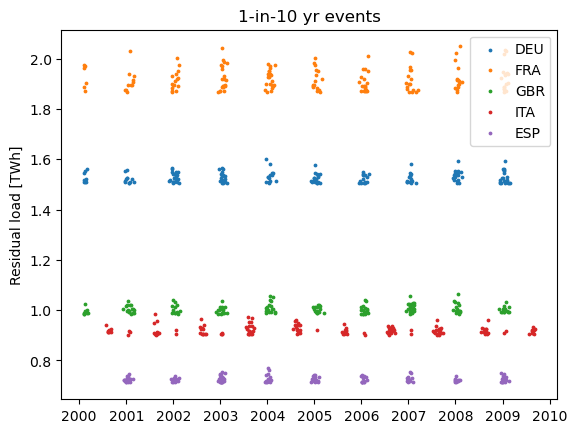

In [10]:
country_ind = 7 #Germany
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 12 #France
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 13 #United Kingdom
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 19 #Italy
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 9 #Spain
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

# Set the labels and title
plt.ylabel('Residual load [TWh]')
plt.title(f'1-in-10 yr events')
plt.legend()
plt.savefig(f'{dir_Figures}/Events_largecountries_w={window}_dte={dt_event}.png', dpi=300, bbox_inches='tight')

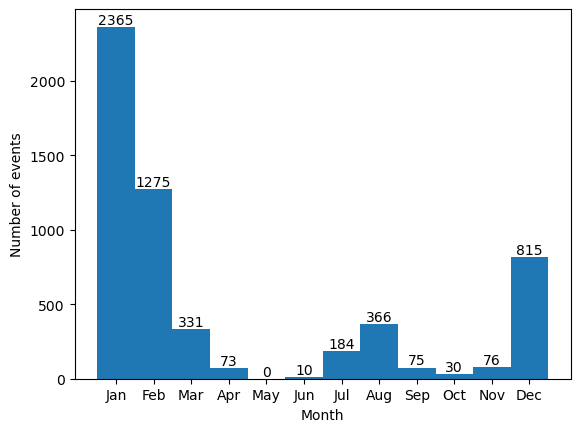

In [11]:
months = ds_events.time.dt.month.values.flatten()
#make a histogram of months
counts, edges, bars = plt.hist(months, bins=np.linspace(0.5,12.5, 13))
plt.xlabel('Month')
plt.bar_label(bars)
plt.ylabel('Number of events')
# make xticks the month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1,13), month_names)
plt.savefig(f'{dir_Figures}/hist_eventmonths_w={window}_dte={dt_event}.png', dpi=300, bbox_inches='tight')

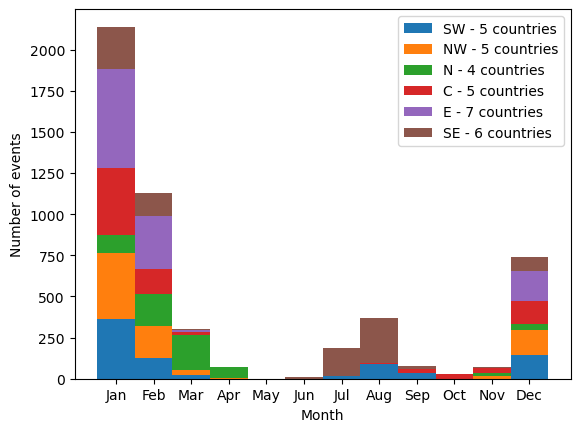

In [12]:
months = ds_events.time.dt.month.values

#Define countries into regions of Europe.
SW = [28, 9, 12, 4, 19]
NW = [13, 17, 1, 25, 7]
N = [8, 26, 33, 11]
C = [27, 0, 32, 31, 6]
E = [10, 21, 20, 34, 22, 16, 29]
SE = [2, 5, 14, 24, 30, 3]

SW_months = np.concatenate([months[i] for i in SW])
NW_months = np.concatenate([months[i] for i in NW])
N_months = np.concatenate([months[i] for i in N])
C_months = np.concatenate([months[i] for i in C])
E_months = np.concatenate([months[i] for i in E])
SE_months = np.concatenate([months[i] for i in SE])

counts, edges, bars = plt.hist([SW_months, NW_months, N_months, C_months, E_months, SE_months], 
         bins=np.linspace(0.5, 12.5, 13), stacked=True, 
         label=['SW - 5 countries', 'NW - 5 countries', 'N - 4 countries', 'C - 5 countries', 'E - 7 countries', 'SE - 6 countries'])

plt.xlabel('Month')
plt.ylabel('Number of events')
# make xticks the month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1,13), month_names)
plt.legend()
plt.savefig(f'{dir_Figures}/hist_regionmonths_w={window}_dte={dt_event}.png', dpi=300, bbox_inches='tight')

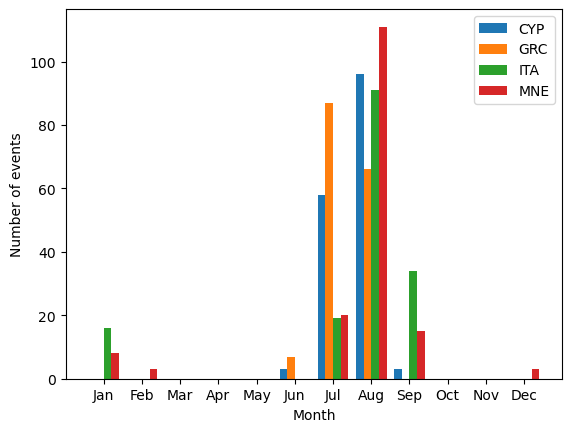

In [13]:
plt.hist(ds_events.time[[5,14,19,24]].T.dt.month,  bins=np.linspace(0.5,12.5, 13), label = countries[[5,14,19,24]])
plt.legend()
plt.xlabel('Month')
plt.ylabel('Number of events')
# make xticks the month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1,13), month_names)
plt.savefig(f'{dir_Figures}/hist_summercountries_w={window}_dte={dt_event}.png', dpi=300, bbox_inches='tight')

Now start to look at co-occurence between countries

In [14]:
import time

co_occurrences = np.zeros((num_countries, num_countries), dtype=float)
df_cooccurrences_list = []

for country_1, country_2 in tqdm(itertools.product(ds_events.country.values, repeat=2)):

    # Precompute selections
    id_country_1 = np.where(countries == country_1)[0][0]
    id_country_2 = np.where(countries == country_2)[0][0]
    run_country_1 = ds_events.run.sel(country=country_1).values
    run_country_2 = ds_events.run.sel(country=country_2).values
    time_country_1 = ds_events.time.sel(country=country_1).values
    time_country_2 = ds_events.time.sel(country=country_2).values

    for i in range(num_events):
        dt = np.abs(time_country_2 - time_country_1[i])
        timeok = dt <= np.timedelta64(dt_cooccur, 'D')
        
        run_1 = run_country_1[i]
        run_2 = run_country_2[timeok]

        sum_run = np.sum(run_1 == run_2)
        co_occurrences[id_country_1, id_country_2] += sum_run 

        if sum_run > 0:
            for j in range(sum_run):
                # Combine the conditions
                condition = (timeok) & (run_1 == run_country_2)
                times = time_country_2[condition]
                # Get the indices of non-NaN values
                non_nan_indices = np.argwhere(~pd.isnull(times)).flatten()
                jth_non_nat = times[non_nan_indices[j]]                
                df_cooccurrences_list.append({'country_1': country_1, 'country_2': country_2, 
                                                'date_1': time_country_1[i], 
                                                'date_2': jth_non_nat, 
                                                'run': int(run_1[1:])})
# # Convert list of dicts to DataFrame
df_cooccurrences = pd.DataFrame(df_cooccurrences_list)

0it [00:00, ?it/s]

In [18]:
# Sum up the co-occurrences over all runs
co_occurrences = xr.DataArray(
    co_occurrences,
    coords={'country_1': countries, 'country_2': countries},
    dims=['country_1', 'country_2']
)

co_occurrences_plot = co_occurrences.copy()

np.fill_diagonal(co_occurrences_plot.values, np.nan) #fill main diagonal with nans, countries cannot co-occur with themselves

plt.figure(figsize=(10, 8))
cmap = matplotlib.colormaps["Reds"]
cmap.set_bad(color='0.8')

sns.heatmap(co_occurrences_plot, cmap=cmap)
# Now make the xticks the country identifiers from country_name
plt.xticks(np.arange(num_countries) + 0.5, countries, rotation=90)
plt.yticks(np.arange(num_countries) + 0.5, countries, rotation=0)
plt.close()
# plt.savefig(f'{dir_Figures}/heatmap_co_occurrence_w={window}_dte={dt_event}_dtc={dt_cooccur}.png', dpi=300, bbox_inches='tight')

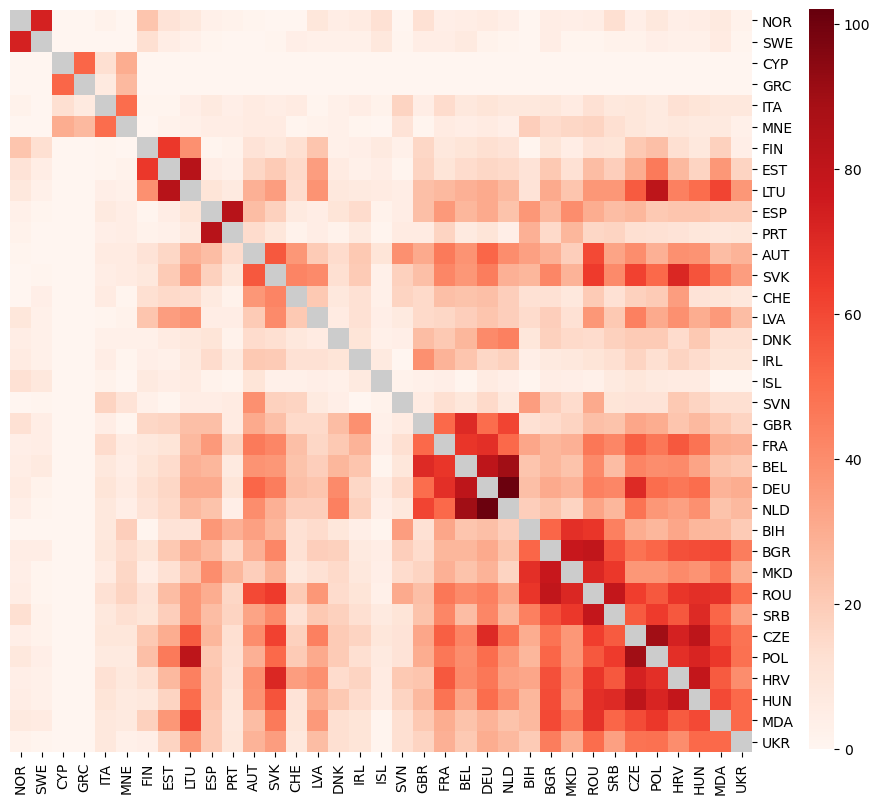

In [16]:
max_co_oc = np.max(co_occurrences_plot).values + 1 #add one so that maximum is not grey

# Create a colormap that maps main diagonal to grey (above the maximum co-occurrence between different countries) and the rest of the values to the original colormap
cmap_modified = cmap
cmap_modified.set_over('0.8')

# Plot the clustermap with the modified colormap and vmin set to 0
cg = sns.clustermap(co_occurrences, cmap=cmap_modified, method='ward', xticklabels=countries, yticklabels=countries, vmax=max_co_oc)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([1, 0.06, 0.025, 0.74])
plt.savefig(f'{dir_Figures}/clusteredheatmap_co_occurrence_w={window}_dte={dt_event}_dtc={dt_cooccur}.png', dpi=300, bbox_inches='tight')

In [17]:
np.save(f'../Results/co_occurrences_w={window}_{rundate}.npy', co_occurrences.values)
df_cooccurrences.to_csv(f'../Results/df_co_occurrences_w={window}_{rundate}.csv', index=False)

In [31]:
c_1 = 'FRA'
c_2 = 'BEL'

co = df_cooccurrences[(df_cooccurrences['country_1'] == c_1) & (df_cooccurrences['country_2'] == c_2)]

co_self = df_cooccurrences[(df_cooccurrences['country_1'] == c_1) & (df_cooccurrences['country_2'] == c_1)]

co = co.copy() #not really necessary, but prevents a warning
co_self = co_self.copy()

co['key'] = co['date_1'].astype(str) + '-' + co['run'].astype(str)

# Removing duplicates (values where 1 event in country 1 co-occurs with multiple events in country 2)
co = co[~co['key'].duplicated()]

num_co = len(co)

co_self['key'] = co_self['date_1'].astype(str) + '-' + co_self['run'].astype(str)

noco = co_self[~co_self['key'].isin(co['key'])]
num_noco = len(noco)

160